In [291]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

input_data = pd.read_csv("resources/KNN/dataset_wine.csv")
x_init = input_data[input_data.columns[1:]].to_numpy()
y_init = input_data[input_data.columns[:1]].to_numpy()

c1_xs = []
c2_xs = []
c3_xs = []

x_norm = MinMaxScaler().fit_transform(x_init)
xs = TSNE(n_components=2).fit_transform(x_norm)
xs_PCA = PCA(n_components=2).fit_transform(x_norm)

minus1 = lambda x: x - 1
vfunc = np.vectorize(minus1)
y_init = vfunc(y_init)


def y_to_onehot(ys):
    y_one_hot = np.empty((0, 3), int)
    for i in range(len(ys)):
        if ys[i][0] == 1:
            y_one_hot = np.append(y_one_hot, np.array([[1, 0, 0]]), axis=0)
            c1_xs.append(xs[i])
        elif ys[i][0] == 2:
            y_one_hot = np.append(y_one_hot, np.array([[0, 1, 0]]), axis=0)
            c2_xs.append(xs[i])
        elif ys[i][0] == 3:
            y_one_hot = np.append(y_one_hot, np.array([[0, 0, 1]]), axis=0)
            c3_xs.append(xs[i])
    return y_one_hot


ys = y_to_onehot(y_init)
dim = len(x_norm[0])

In [102]:
import matplotlib.pyplot as plt

def draw_tags_plot(xs, classes, title):
    x_axis = [x[0] for x in xs]
    y_axis = [x[1] for x in xs]

    min_x = min(x_axis) - 1
    max_x = max(x_axis) + 1

    min_y = min(y_axis) - 1
    max_y = max(y_axis) + 1

    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    for i in range(len(xs)):
        if classes[i] == 1:
            plt.scatter(x_axis[i], y_axis[i], s=25, color='r')
        elif classes[i] == 2:
            plt.scatter(x_axis[i], y_axis[i], s=25, color='g')
        else:
            plt.scatter(x_axis[i], y_axis[i], s=25, color='b')
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    plt.title(title)
    plt.show()
    
    
def draw_plot(xs, ys, title, xlabel, ylabel):
    plt.plot(xs, ys)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

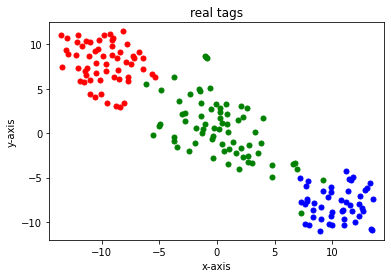

In [103]:
draw_tags_plot(xs, y_init, 'real tags')

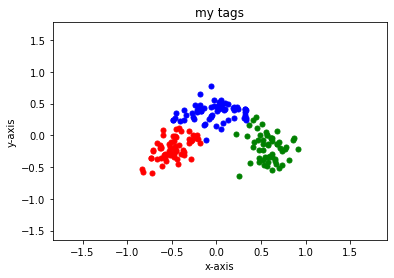

In [104]:
draw_tags_plot(xs_PCA, my_tags, 'my tags')

In [303]:
import math
import random


def dist(a: list, b: list) -> float:
    assert len(a) == len(b)
    s = 0
    for i in range(len(a)):
        s += math.pow(b[i] - a[i], 2)
    return math.sqrt(s)


def gen_random_vector(n: int) -> list:
    res = []
    for _ in range(n):
        res.append(random.random())
    return res


def init_clusters(k: int) -> list:
    clusters = []
    for _ in range(k):
        clusters.append(gen_random_vector(dim))
    return clusters


def classify_points(xs: list, clusters: list) -> list:
    res = []
    for x in xs:
        min_dist = 1000
        clust_number = -1
        for i in range(len(clusters)):
            if dist(clusters[i], x) < min_dist:
                min_dist = dist(clusters[i], x)
                clust_number = i
        res.append(clust_number)
    return res


def get_points_from_clust(xs: list, clust_tags: list, clust_num: int) -> list:
    assert len(xs) == len(clust_tags)
    res = []
    for i in range(len(xs)):
        if clust_tags[i] == clust_num:
            res.append(xs[i])
    return res


def find_center(points: list, dim: int) -> list:
    sum_vec = [0 for _ in range(dim)]
    if len(points) == 0:
        return gen_random_vector(dim)
    for p in points:
        assert len(p) == len(sum_vec)
        for i in range(dim):
            sum_vec[i] += p[i]
    return list(map(lambda x: x / len(points), sum_vec))


def k_means(xs: list, k: int) -> list:
    eps = 1e-8
    max_iters = 100000
    clusters = init_clusters(k)
    new_tags = classify_points(xs, clusters)
    for _ in range(max_iters):
        new_clusters = []
        for i in range(len(clusters)):
            cur_points = get_points_from_clust(xs, new_tags, i)
            new_clusters.append(find_center(cur_points, dim))
        diff_sum = 0
        new_tags = classify_points(xs, new_clusters)
        for i in range(len(clusters)):
            diff_sum += dist(clusters[i], new_clusters[i])
        clusters = new_clusters
        if diff_sum <= eps:
            break
    print(f_measure(y_init, new_tags))
    return new_tags

0.04987727701475345


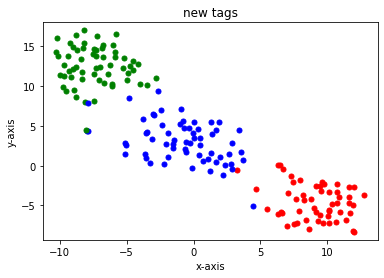

In [304]:
draw_tags_plot(xs, k_means(x_norm, 3), 'new tags')

0.2636630470358639


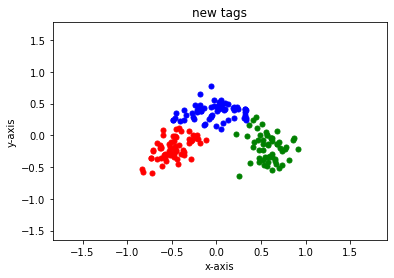

In [305]:
draw_tags_plot(xs_PCA, k_means(x_norm, 3), 'new tags')

In [300]:
def get_confusion_matrix(k, expected, predicted):
    """
    expected -- begins from 0 -- 2 dimensional (e.g. [[0], [1], [0], ...])
    predicted -- begins from 0 -- numpy array
    """
    assert len(expected) == len(predicted)
    confusion_matrix = [[0] * k, [0] * k, [0] * k]
    for i in range(len(expected)):
        predicted_class = predicted[i]
        actual_class = expected[i][0]
        if predicted[i] == expected[i]:
            confusion_matrix[predicted_class][predicted_class] += 1
        else:
            confusion_matrix[actual_class][predicted_class] += 1
    return confusion_matrix


def f1(p, r):
    return 2 * p * r / (p + r)


def get_f_measure(k, expected, predicted):
    matrix = get_confusion_matrix(k, expected, predicted)
    row_sum = [0] * k
    column_sum = [0] * k
    true_positive = [0.0] * k
    amount = 0

    for i in range(k):
        row = matrix[i]
        for j in range(k):
            x = row[j]
            amount += x
            row_sum[i] += x
            column_sum[j] += x
            if i == j:
                true_positive[i] = x

    recall = [0.0] * k
    prec = [0.0] * k
    recall_sum = 0
    prec_sum = 0
    micro_sum = 0

    for i in range(k):
        if true_positive[i] == 0:
            continue
        prec[i] = float(true_positive[i]) / row_sum[i]
        prec_sum += prec[i] * row_sum[i]

        recall[i] = float(true_positive[i]) / column_sum[i]
        recall_sum += recall[i] * row_sum[i]

        micro_sum += f1(recall[i], prec[i]) * row_sum[i]

    prec_average = prec_sum / amount
    recall_average = recall_sum / amount

    macro = f1(prec_average, recall_average)
    micro = micro_sum / amount

    return macro


def f_measure(expected, predicted):
    return get_f_measure(3, expected, predicted)

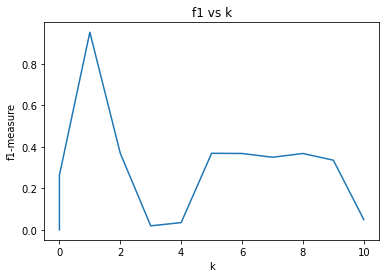

In [302]:
from sklearn.metrics import f1_score

x_plot = [0]
y_plot = [0]

for k in range(11):
    tags = k_means(x_norm, 3)
    f_score = f_measure(y_init, tags)
    x_plot.append(k)
    y_plot.append(f_score)

draw_plot(x_plot, y_plot, 'f1 vs k', 'k', 'f1-measure')